# 0.0. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import inflection
import math
import numpy      as np
import pandas     as pd
import pickle
import random
import requests
import seaborn    as sns
import xgboost    as xgb

from boruta                import BorutaPy
from IPython.display       import Image
from matplotlib            import pyplot    as plt
from matplotlib.gridspec   import GridSpec
from scipy                 import stats     as ss
from seaborn.matrix        import heatmap
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from tabulate              import tabulate

## 0.1. Helper Functions

In [66]:
# set plots size
plt.rcParams['figure.figsize'] = [ 30, 10 ]

# Cramer's V calculus abstraction
def cramer_v( x, y ):
    # confusion matrix
    cm = pd.crosstab(x,y).values

    # sum of cm values
    n = cm.sum()

    # number of rows and columns
    r, k = cm.shape

    # contingency table
    chi2 = ss.chi2_contingency(cm)[0]

    # cramer's v bias correction (overestimation tendency)
    chi2corr = max( 0, chi2-(k-1)*(r-1)/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt( ( chi2corr/n )/( min( kcorr-1, rcorr-1 ) ) )

# ML error calculus abstraction
def ml_error( model_name, y, yhat ):
    y = np.expm1(y)
    yhat = np.expm1(yhat)

    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse }, index=[0] )

# Cross Validation method abstraction
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('KFold Number: {}/{}'.format(k,kfold))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )

        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # training dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, yvalidation, yhat )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                  'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                  'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                  'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ),    
                }, index=[0] )

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. Data Description

In [4]:
# copy into a new dataset to keep the progress made until now
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [5]:
# rename columns to snake case
cols_old = df1.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case,cols_old))
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
# checking dataset's size
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [7]:
# checking original data types
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
# fixing date type
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [9]:
# absolute and percentual number of NAs
na_absolute = pd.DataFrame(df1.isna().sum()).reset_index().rename(columns={'index':'feature', 0:'absolute'})
na_percentage = pd.DataFrame(df1.isna().sum()/df1.shape[0]*100).reset_index().rename(columns={'index':'feature', 0:'percentage'})
check_na = pd.merge(na_absolute, na_percentage, how='inner', on='feature')
check_na

,feature,absolute,percentage
0,store,0,0.000000
1,day_of_week,0,0.000000
2,date,0,0.000000
3,sales,0,0.000000
4,customers,0,0.000000
5,open,0,0.000000
6,promo,0,0.000000
7,state_holiday,0,0.000000
8,school_holiday,0,0.000000
9,store_type,0,0.000000


## 1.5. Fillout NAs

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )         

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )                 

# promo_interval
month_map = { 1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' } 
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Change Types

In [11]:
# fixing data types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [13]:
# spliting dataset into numeric and categorical features
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [14]:
# Central Tendency - average/mean, median
_mean   = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
_min      = pd.DataFrame(num_attributes.apply(min)).T
_max      = pd.DataFrame(num_attributes.apply(max)).T
_std      = pd.DataFrame(num_attributes.apply(np.std)).T
_range    = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
_skew     = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
_min,_max,_std,_range,_skew,_kurtosis
ds_num = pd.concat( [ _min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
ds_num.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

ds_num

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.171835,0.0,0.377237,1.739838,1.027039


### 1.7.2. Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

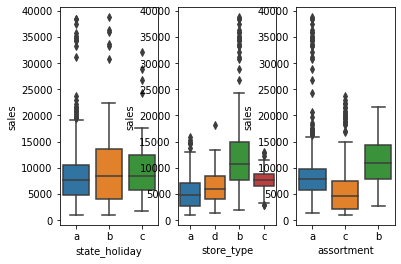

In [16]:
aux1 = df1[(df1['state_holiday'] != '0')&(df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);

In [17]:
df1.to_csv('../data/processed/df1.csv',index=False)

# 2.0 Hypotheses Gathering

## 2.1. Hypotheses' mindmap

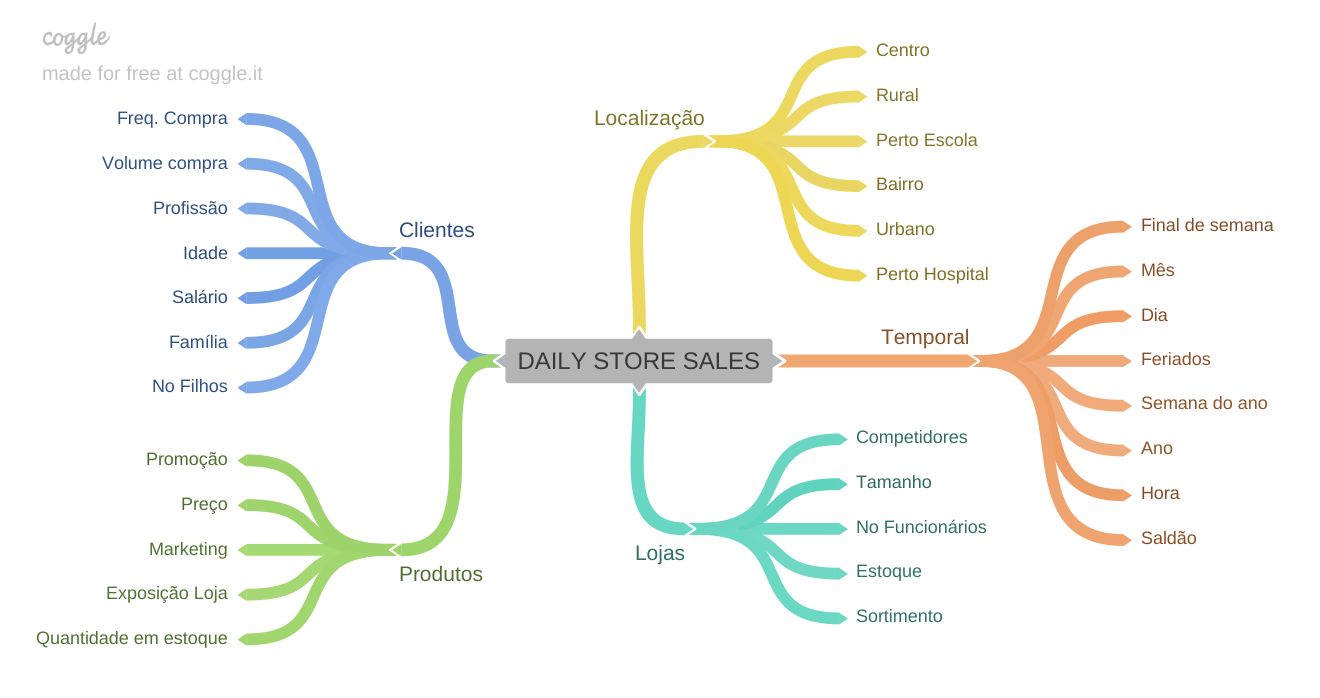

In [18]:
Image('../reports/figures/mindmap_hipothesys.png')

## 2.2. Hypotheses' creation

### 2.2.1. Store Hypotheses

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Product Hypotheses

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3. Time Hypotheses

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Hypotheses' Final List

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

# 3.0 Feature Engineering

In [19]:
# copy into a new dataset to keep the progress made until now
df3 = df1.copy()

In [20]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'],
                                                                  month = x['competition_open_since_month'], 
                                                                  day=1), axis=1 )
df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype(int)

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype(int)

# assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [21]:
df3.to_csv('../data/processed/df3.csv',index=False)

# 4.0. Variables filtering

In [22]:
# copy into a new dataset to keep the progress made until now
df4 = df3.copy()

## 4.1. Rows filtering

In [23]:
# days when the store was closed or didn't sell anything
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

## 4.2. Columns selection

In [24]:
cols_drop = ['customers','open','promo_interval','month_map']
df4 = df4.drop(cols_drop, axis=1)

In [25]:
df4.to_csv('../data/processed/df4.csv',index=False)

# 5.0. Exploratory Data Analysis

In [26]:
# copy into a new dataset to keep the progress made until now
df5 = df4.copy()

## 5.1. Univariate analysis

### 5.1.1. Response Variable

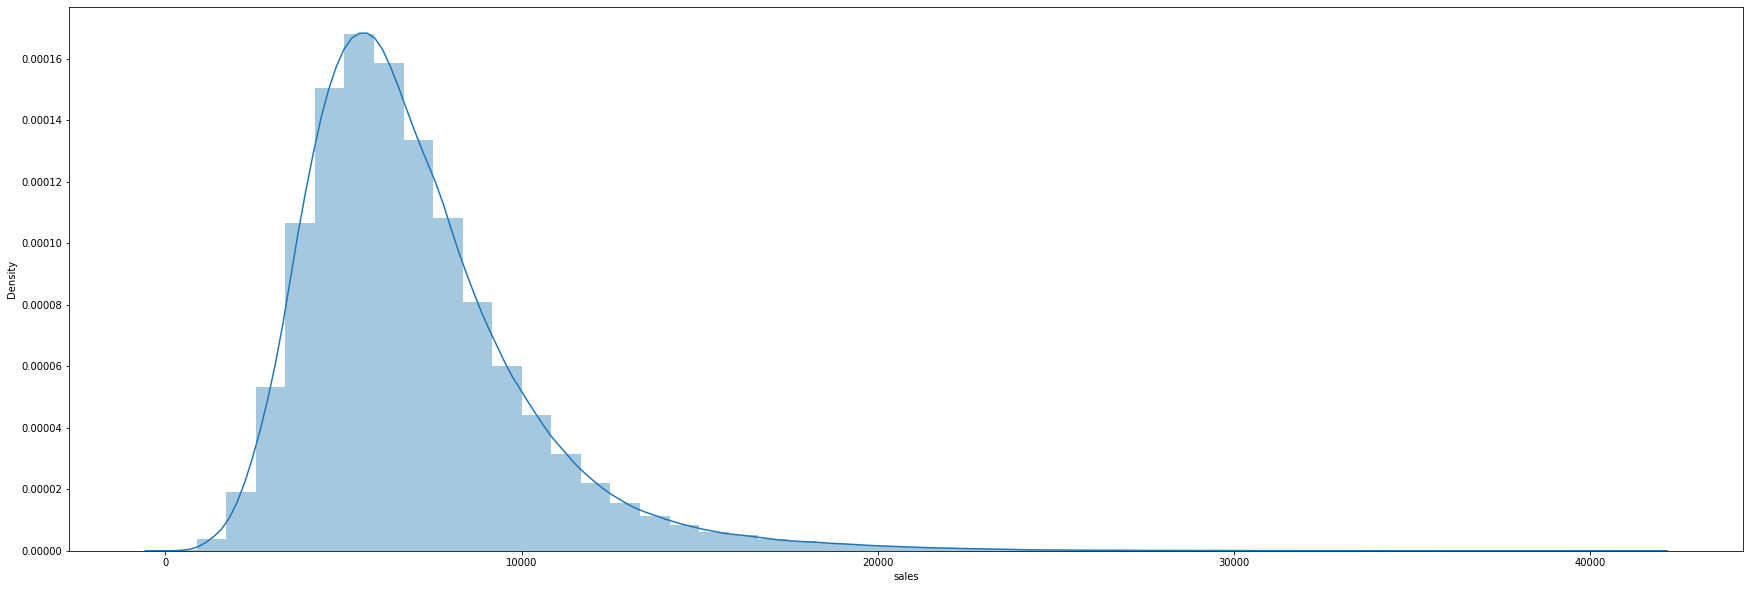

In [67]:
# response variable distribution
sns.distplot(df5['sales']);

### 5.1.2. Numerical Variables

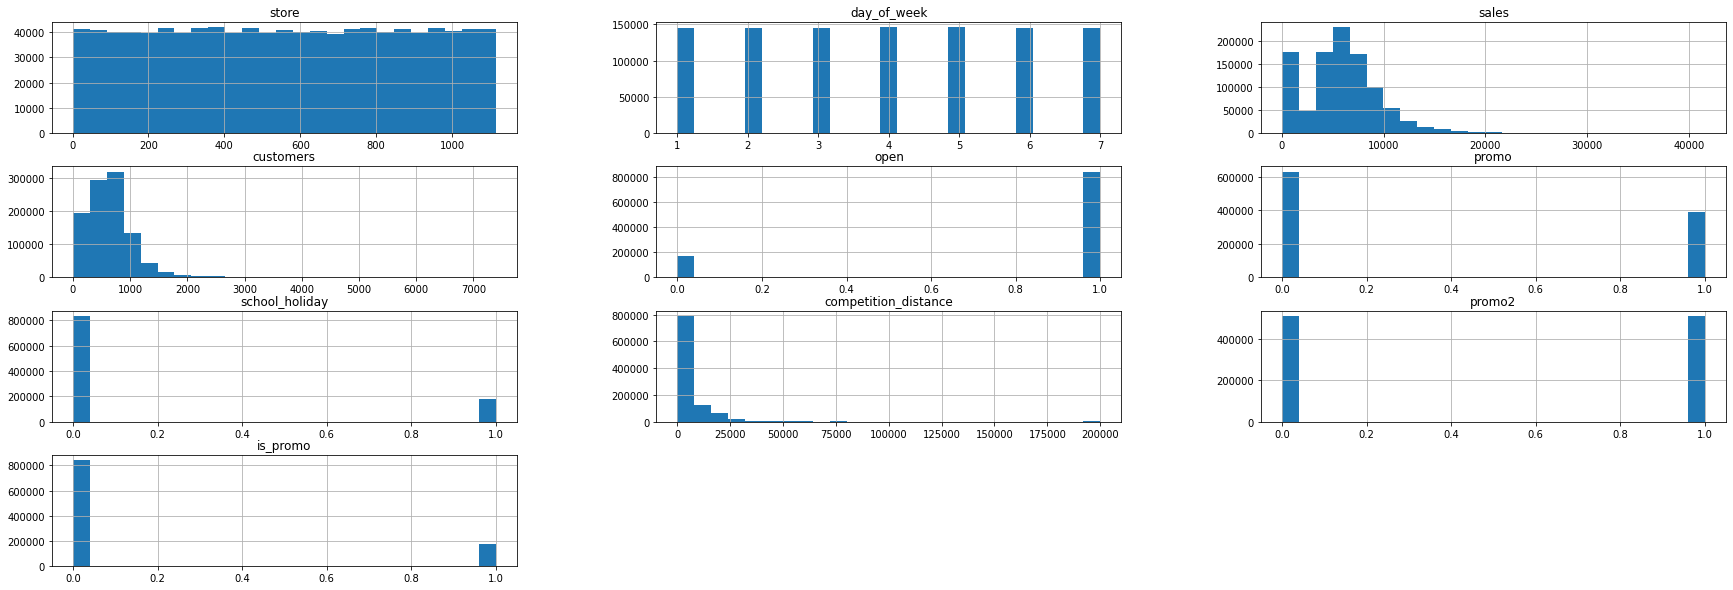

In [68]:
num_attributes.hist(bins=25);

### 5.1.3. Categorical Variables

In [29]:
cat_attributes.head()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
0,0,c,a,9,2008,31,2015,0,Jul
1,0,a,a,11,2007,13,2010,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,12,2006,14,2011,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,9,2009,31,2015,0,Jul
4,0,a,a,4,2015,31,2015,0,Jul


In [30]:
df5['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

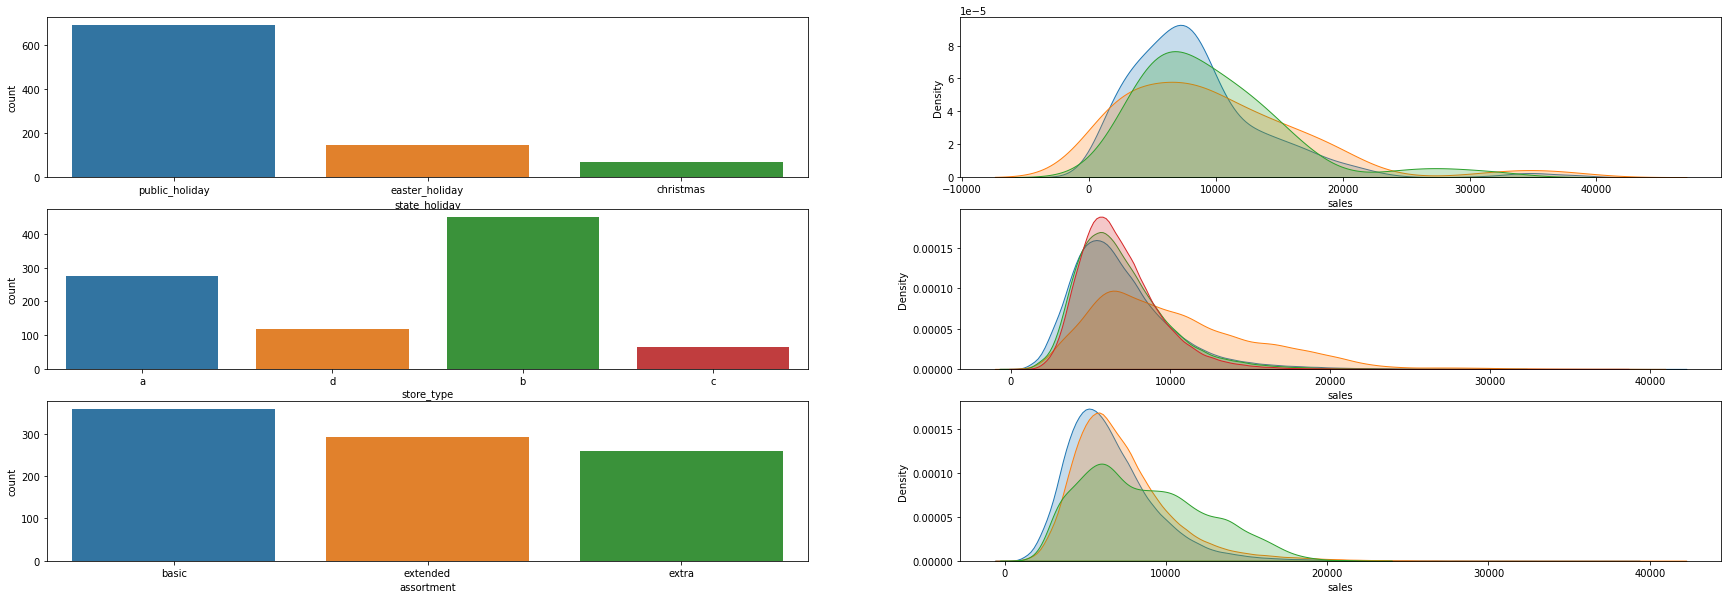

In [69]:
a = df5[(df5['state_holiday'] != 'regular_day') & (df5['state_holiday'] != 'regular_day')]

# state_holiday
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 5.2. Bivariate analysis

### H1. Lojas com maior sortimentos deveriam vender mais.
**Falsa** Lojas com maior sortimento vendem menos

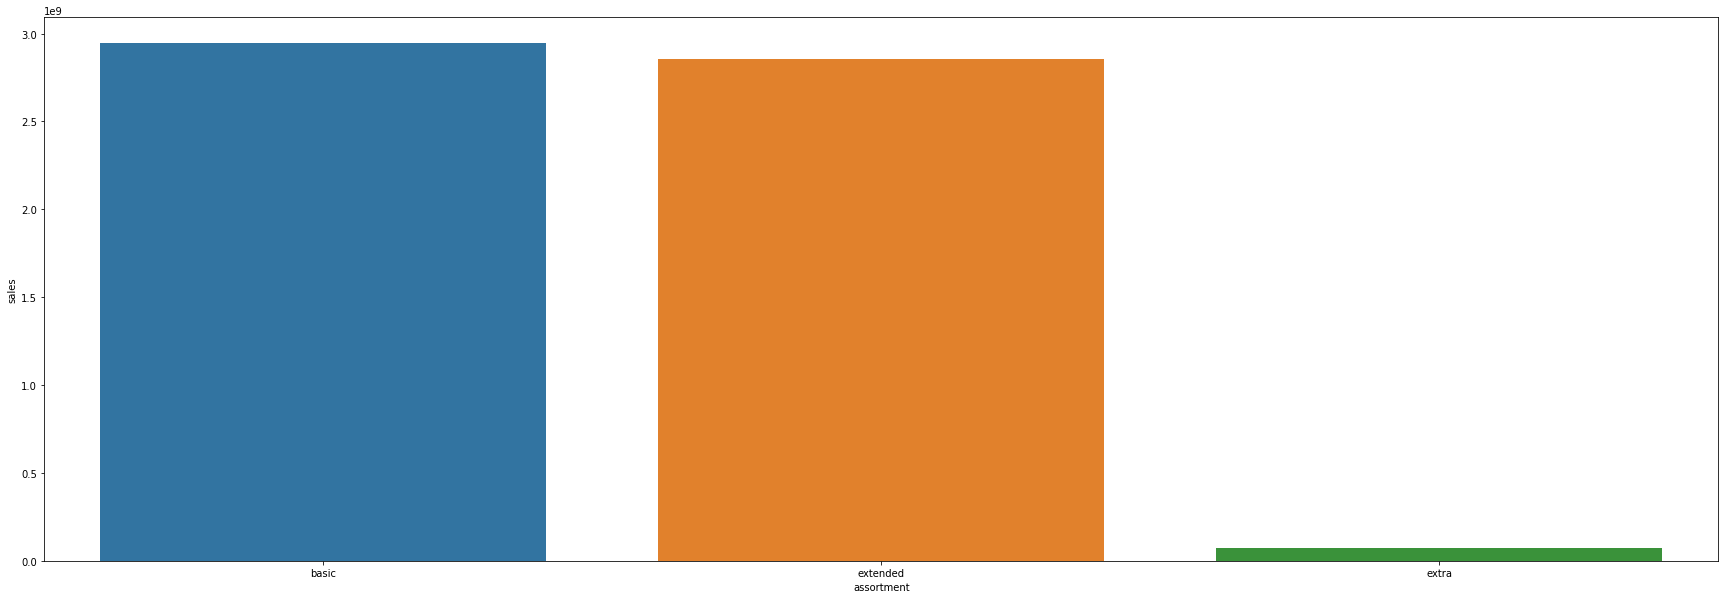

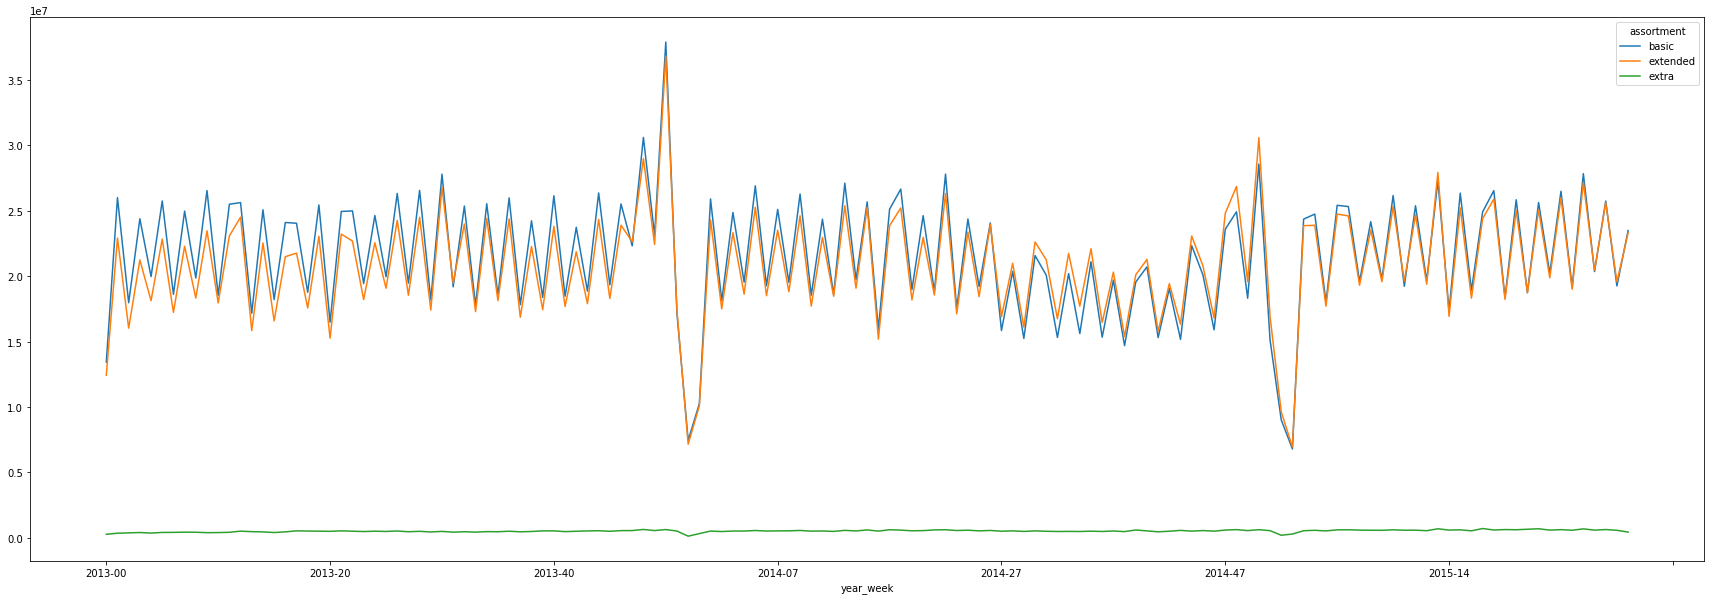

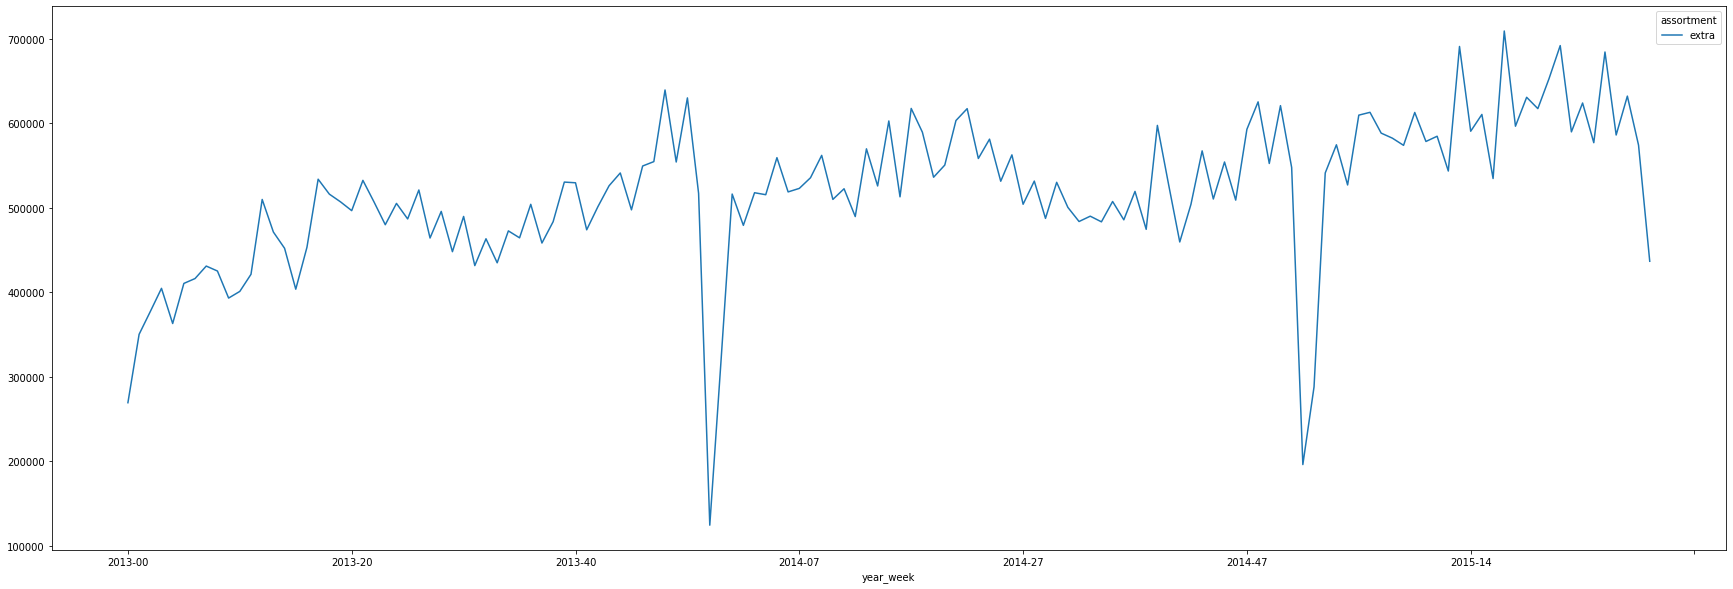

In [70]:
aux1 = df5[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1)

aux2 = df5[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com competidores mais próximos vendem mais.

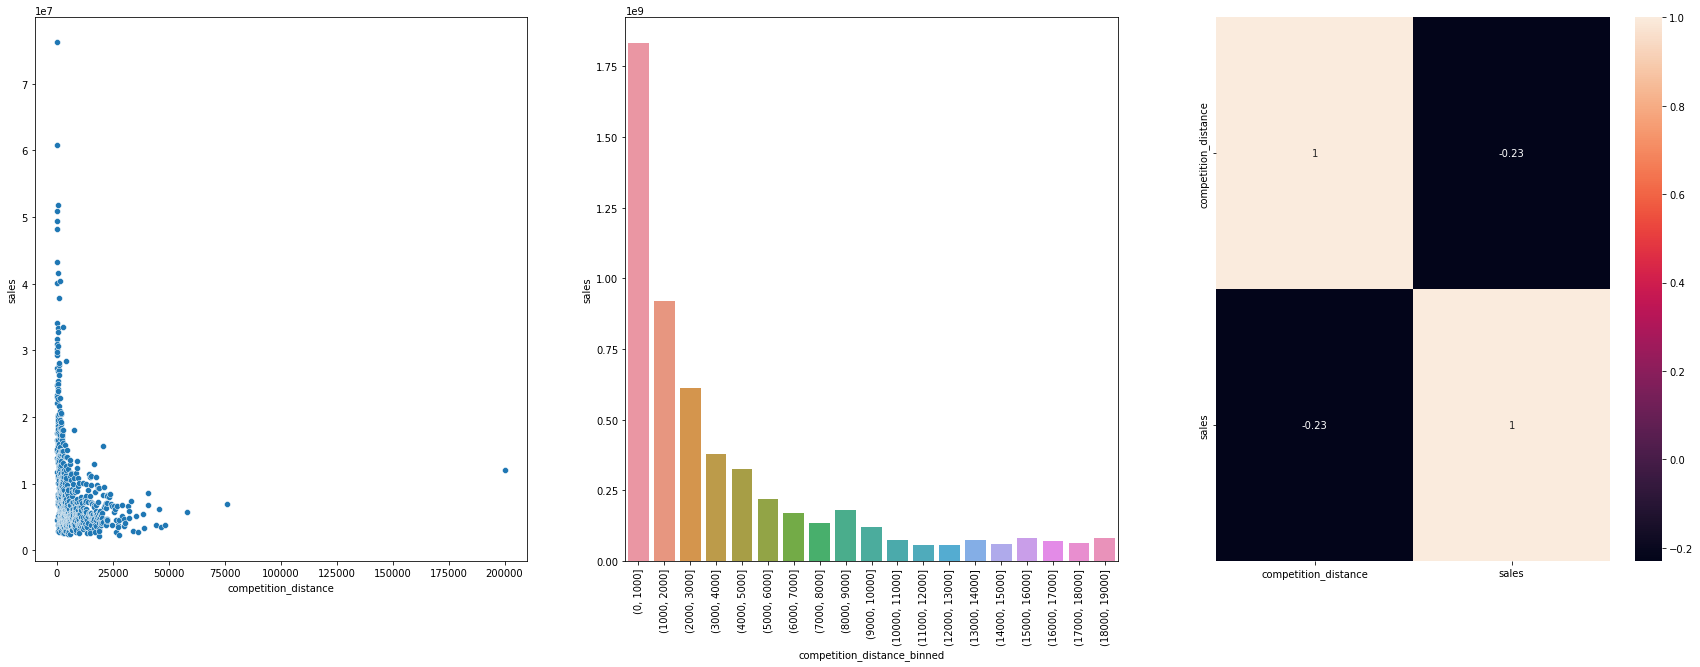

In [71]:
aux1 = df5[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000)) #array de 0 a 20000 de 1000 em 1000
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**Falsa** Lojas com competidores à mais tempo vendem menos.

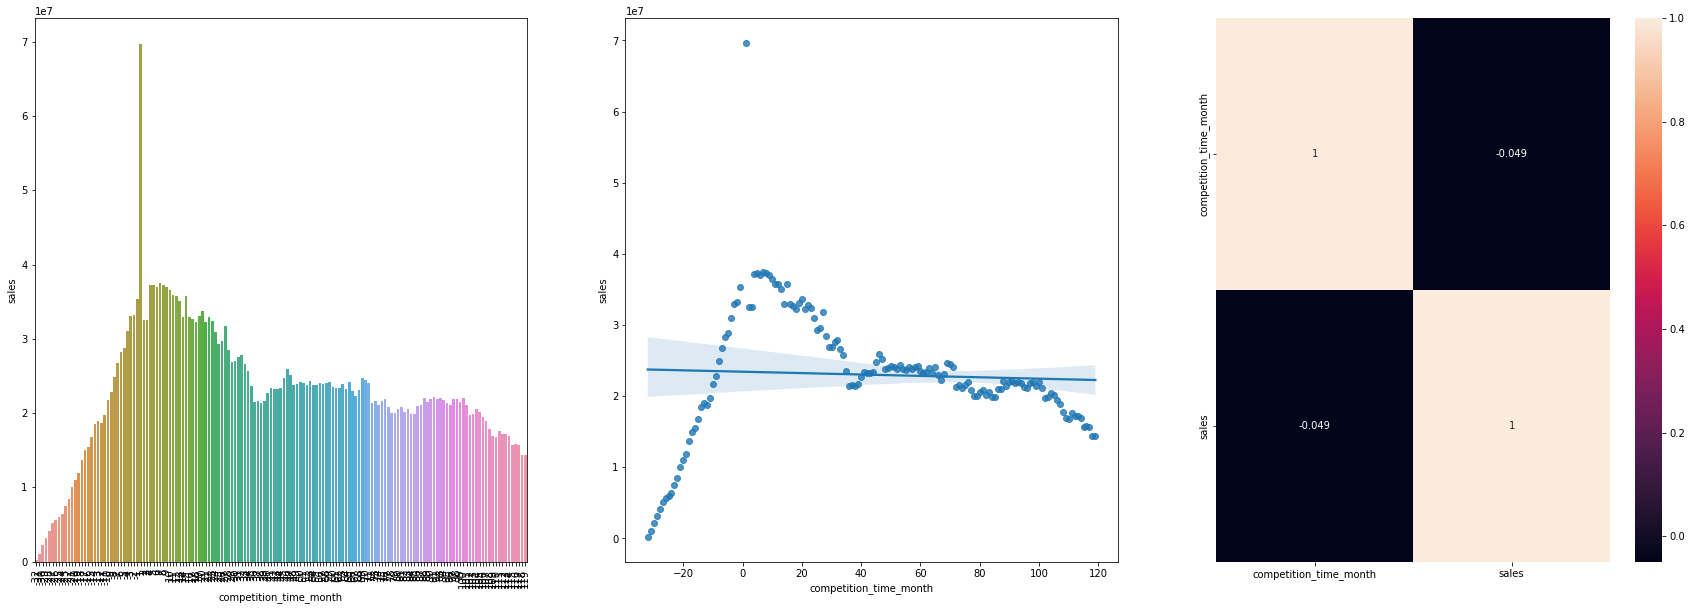

In [72]:
plt.subplot(1,3,1)
aux1 = df5[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'),annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

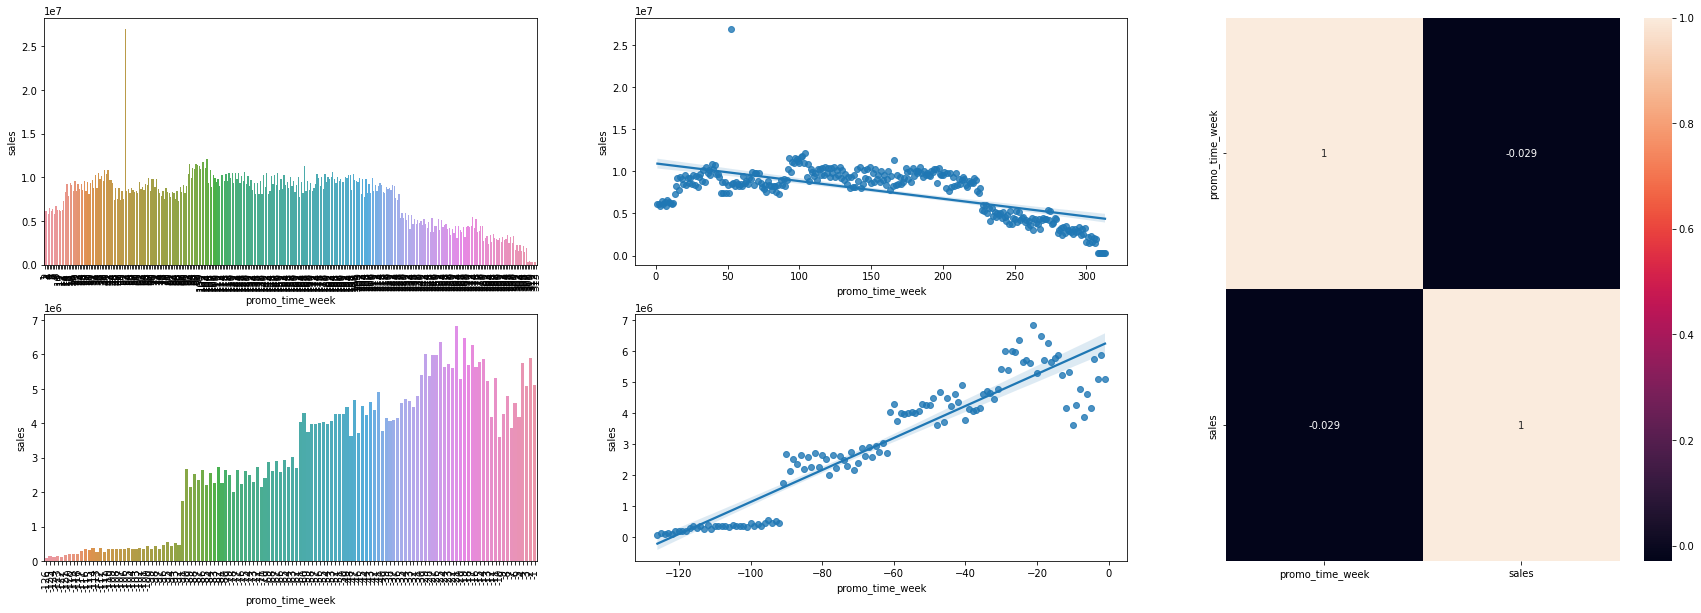

In [73]:
aux1 = df5[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** Lojas com mais promoções consecutivas vendem menos

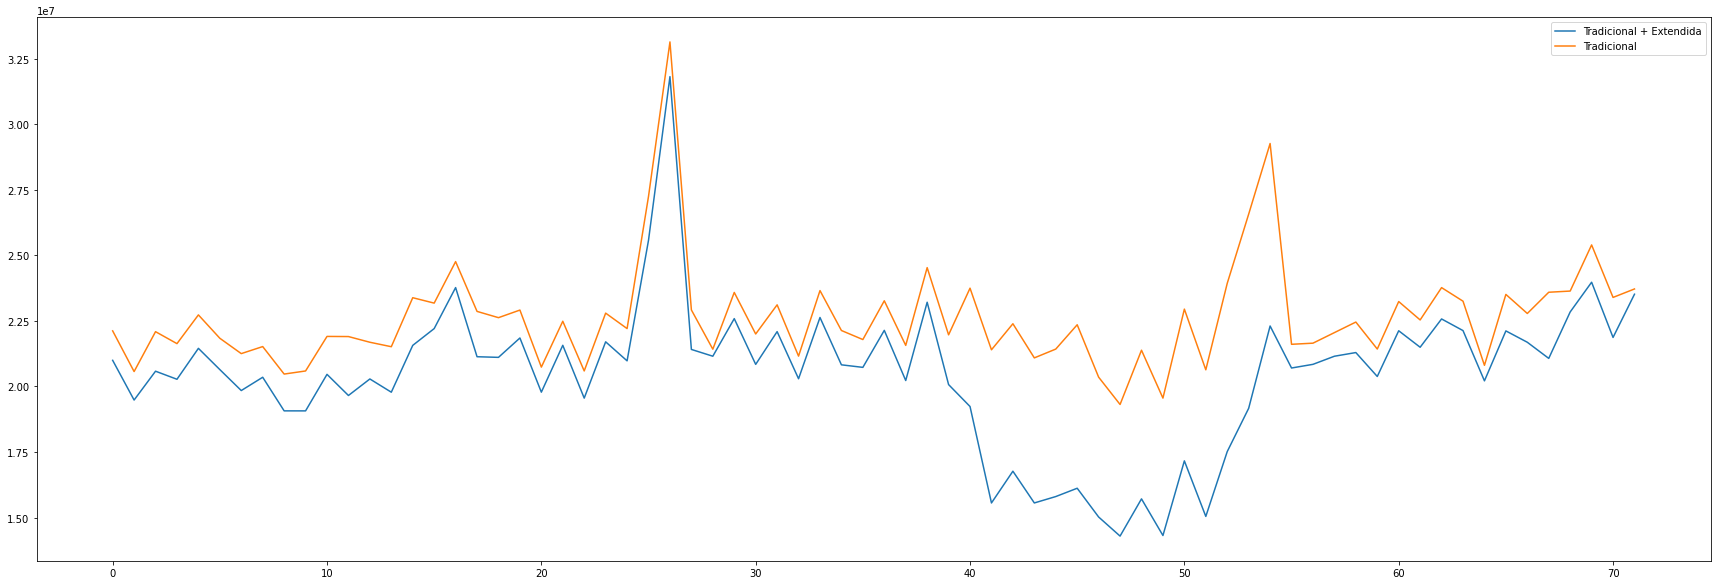

In [74]:
df5[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

aux1 = df5[(df5['promo']==1)&(df5['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux1 = df5[(df5['promo']==1)&(df5['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax = ax)

ax.legend(labels=['Tradicional + Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado do Natal vendem menos.

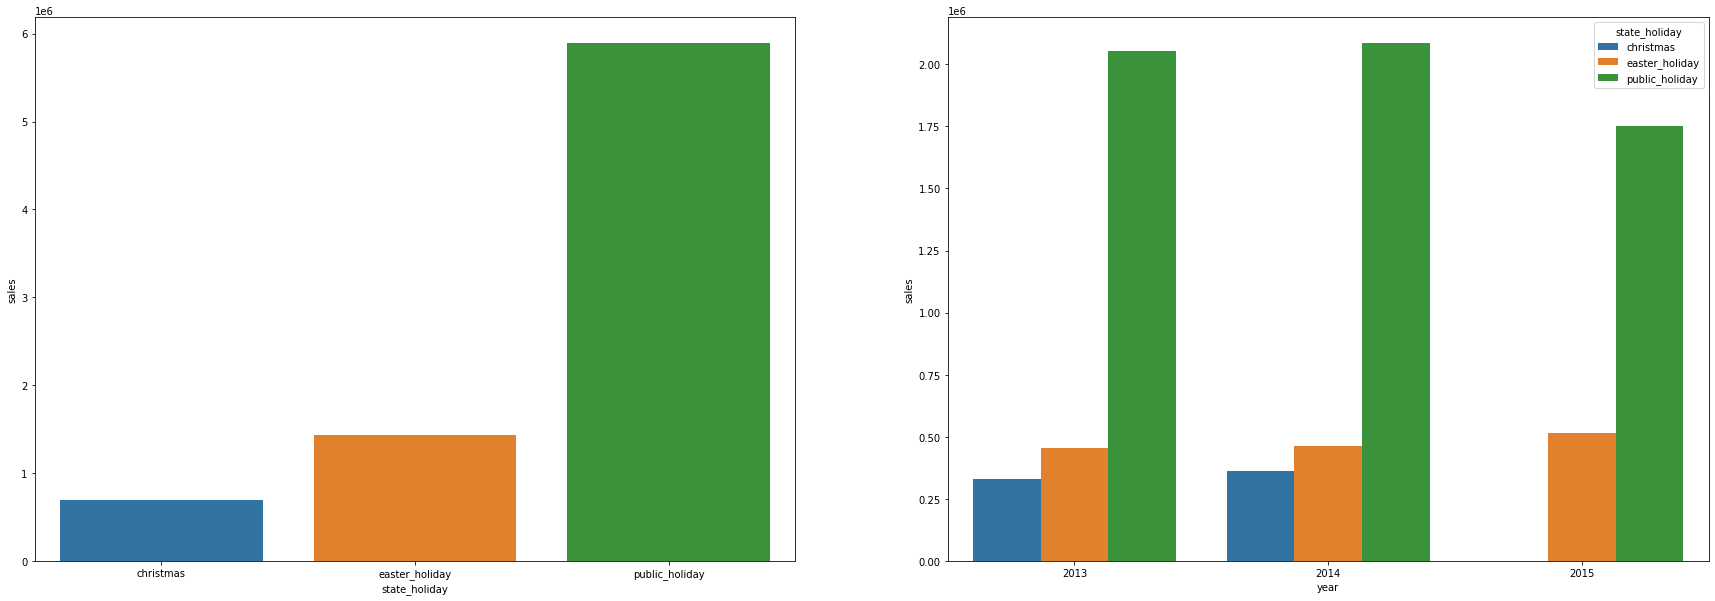

In [75]:
aux = df5[df5['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas tem vendido menos ao longo dos anos

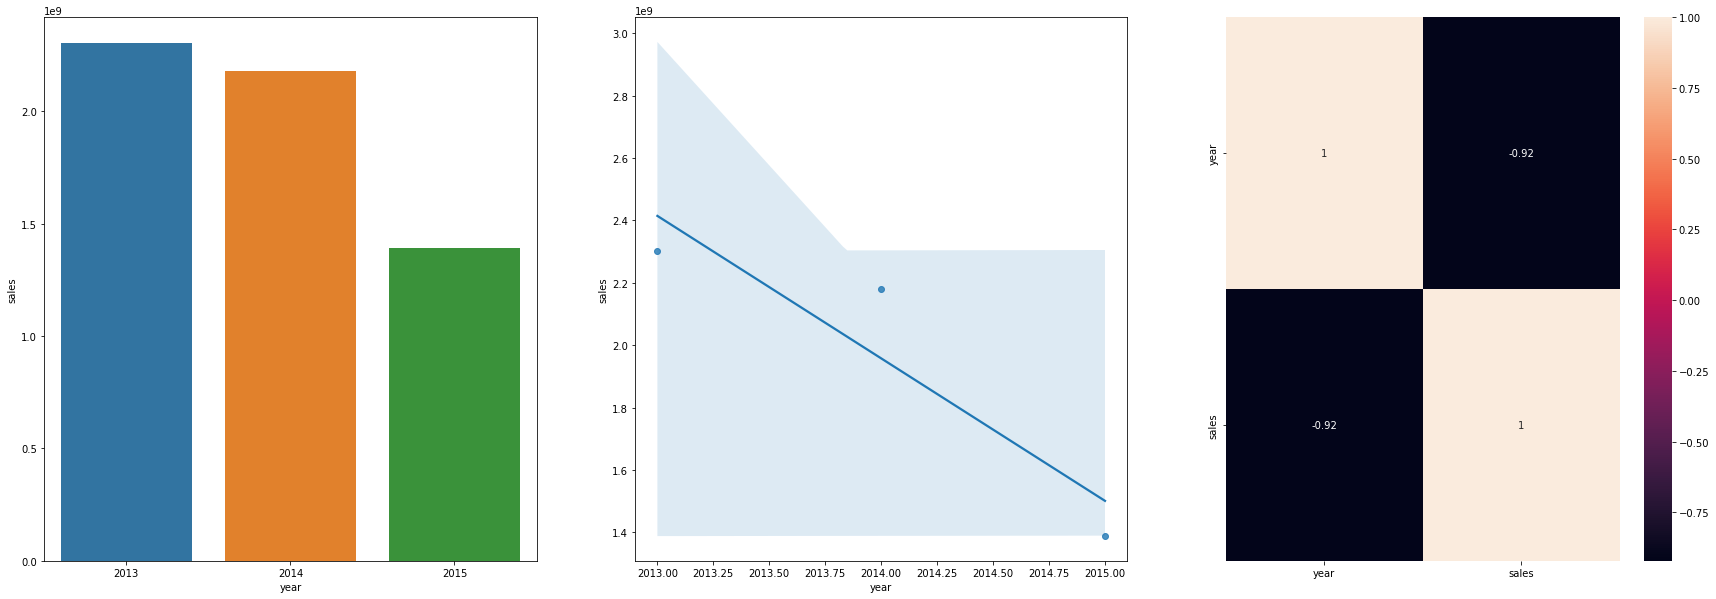

In [76]:
aux1 = df5[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** Lojas vendem menos no segundo semestre do ano

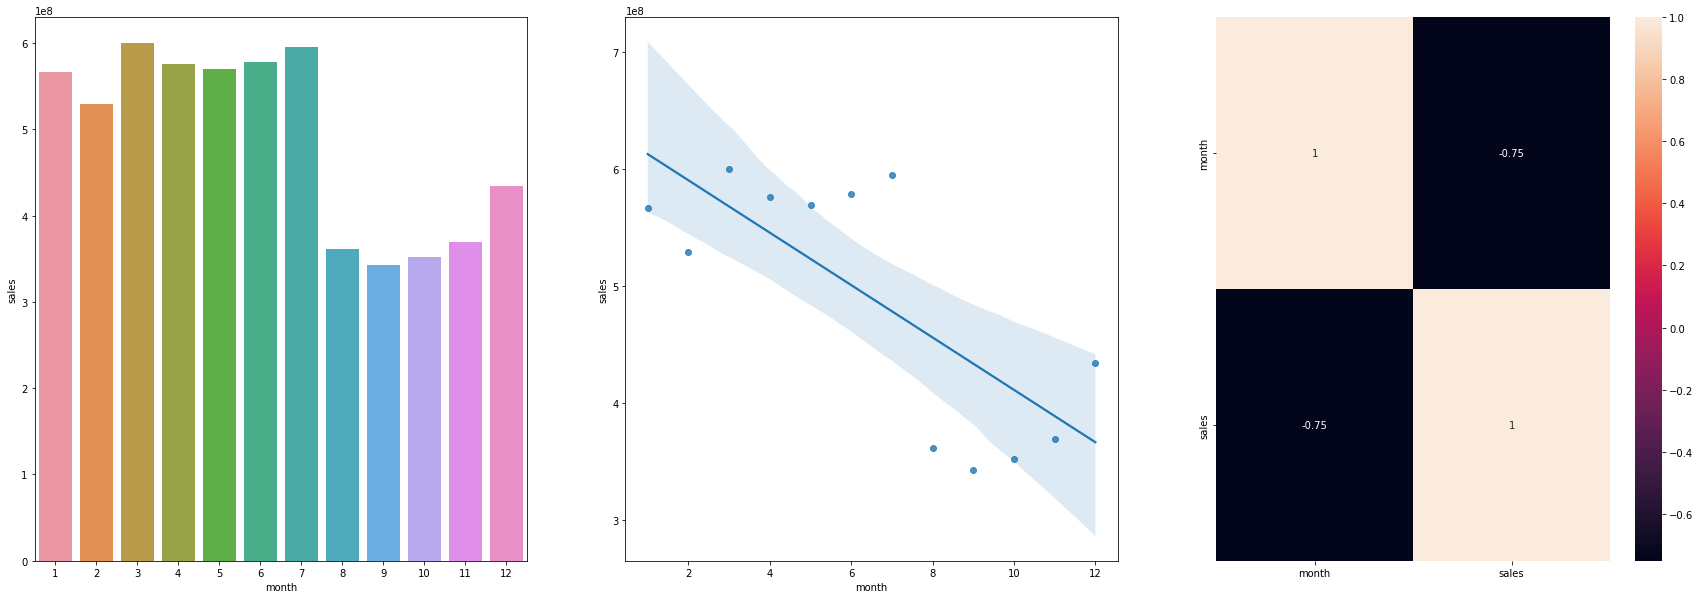

In [77]:
aux1 = df5[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**Falsa** Lojas vendem mais depois do dia 10 de cada mês

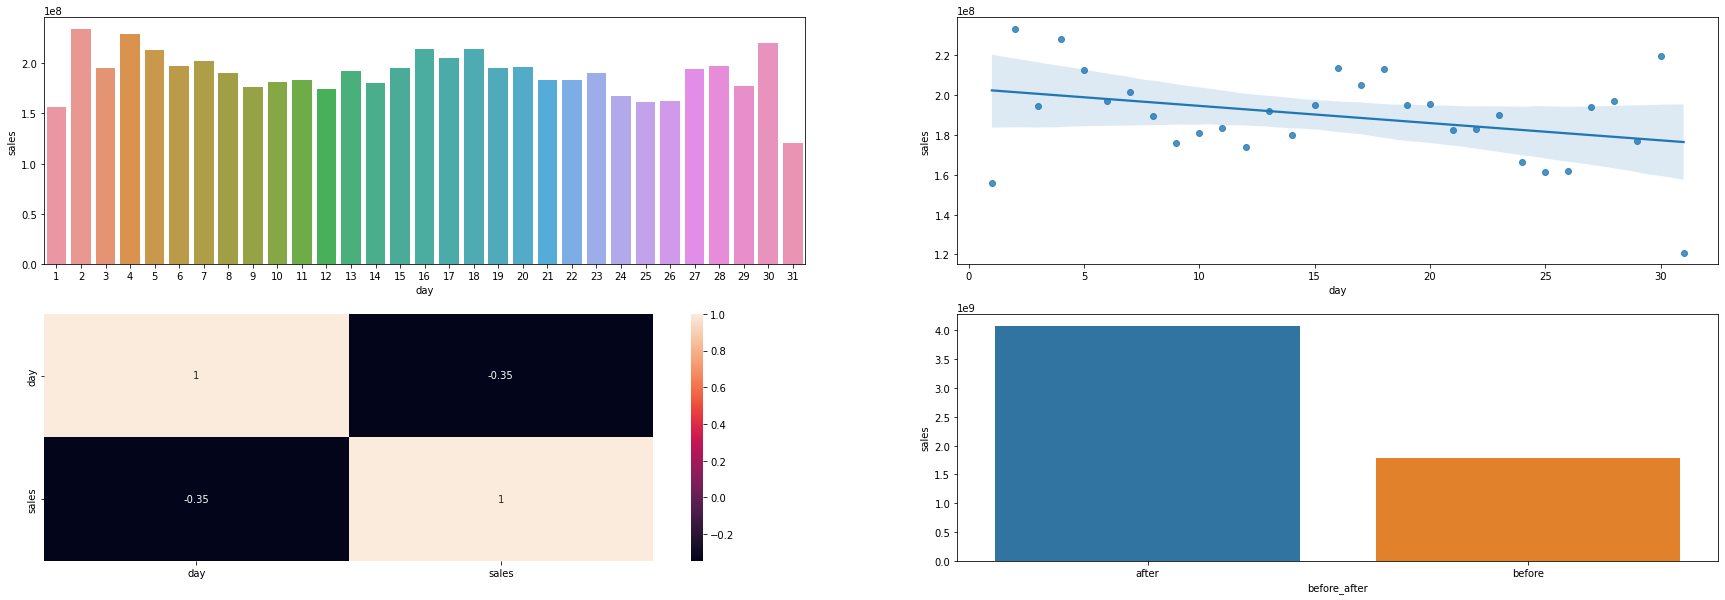

In [78]:
aux1 = df5[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x < 10 else 'after')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
**Verdadeira** Lojas vendem menos nos finais de semana

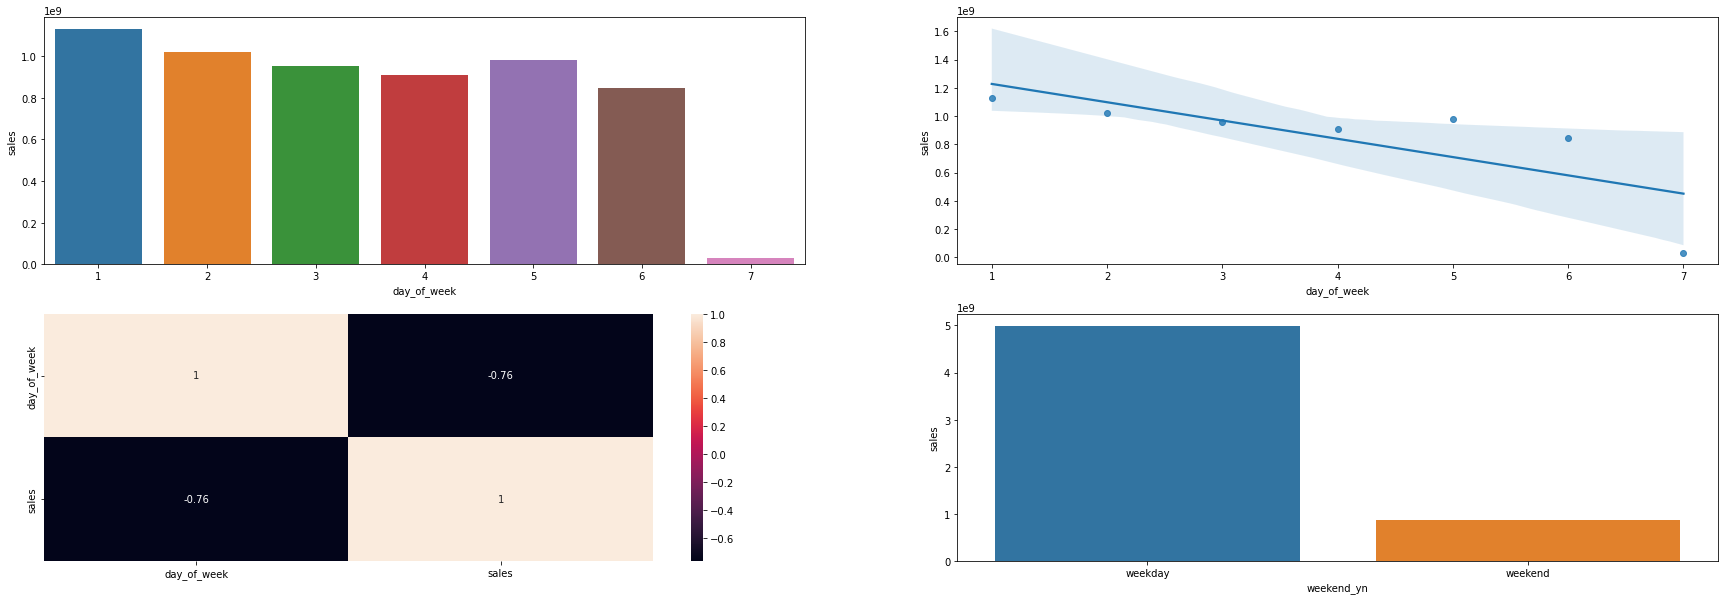

In [79]:
aux1 = df5[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['weekend_yn'] = aux1['day_of_week'].apply(lambda x: 'weekend' if x in(6,7) else 'weekday')
aux2 = aux1[['weekend_yn','sales']].groupby('weekend_yn').sum().reset_index()
sns.barplot(x='weekend_yn',y='sales',data=aux2);

### H12. Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durante os feriados escolares

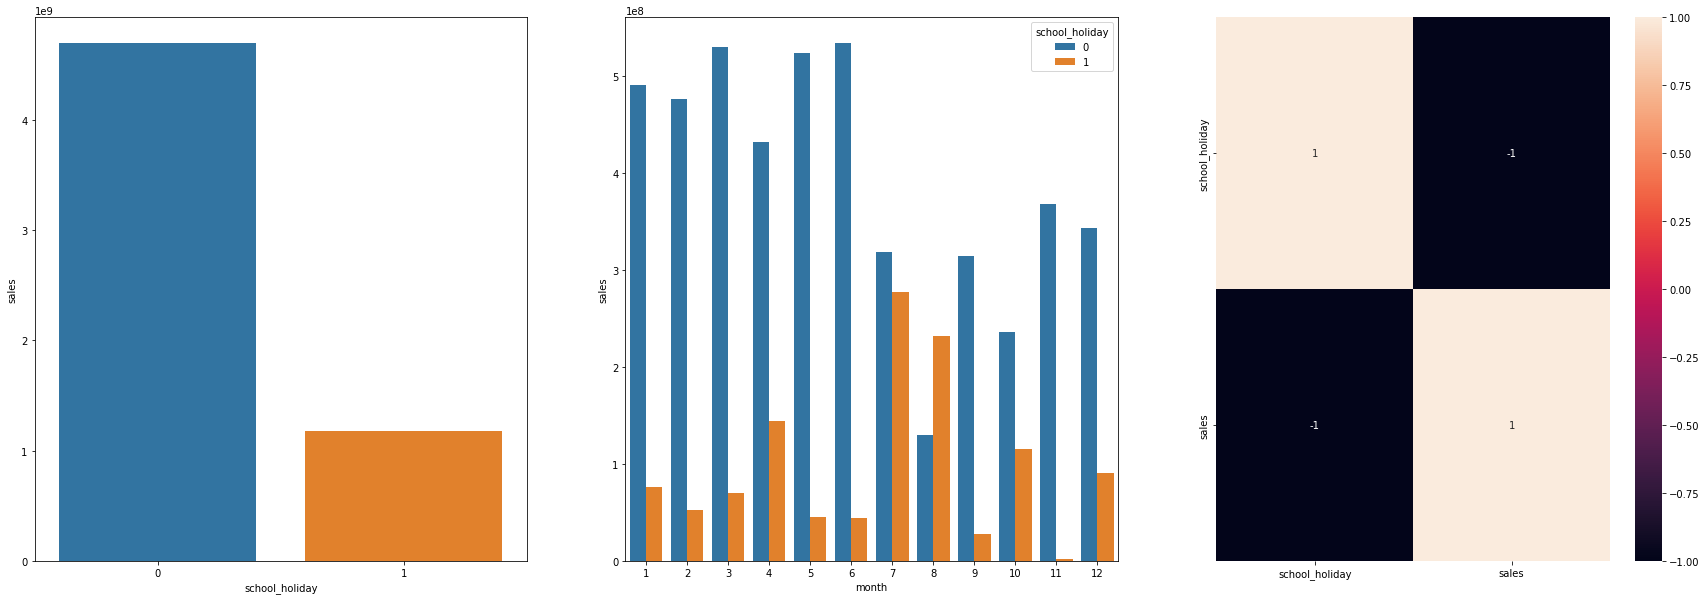

In [80]:
plt.subplot(1,3,1)
aux1 = df5[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
aux2 = df5[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales', hue='school_holiday', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 5.2.1. Hypotheses' summary

In [81]:
tab = [
       ['Hipóteses','Conclusão' ,'Relevância'],
       ['H1'       ,'Falsa'     ,'Baixa'],       
       ['H2'       ,'Falsa'     ,'Média'],       
       ['H3'       ,'Falsa'     ,'Média'],       
       ['H4'       ,'Falsa'     ,'Baixa'],       
       ['H5'       ,'-'         ,'-'],       
       ['H6'       ,'Falsa'     ,'Baixa'],       
       ['H7'       ,'Falsa'     ,'Média'],       
       ['H8'       ,'Falsa'     ,'Alta'],       
       ['H9'       ,'Falsa'     ,'Alta'],       
       ['H10'      ,'Verdadeira','Alta'],       
       ['H11'      ,'Verdadeira','Alta'],       
       ['H12'      ,'Verdadeira','Baixa']
]

print(tabulate(tab,headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 5.3. Multivariate analysis

### 5.3.1. Numerical Attributes

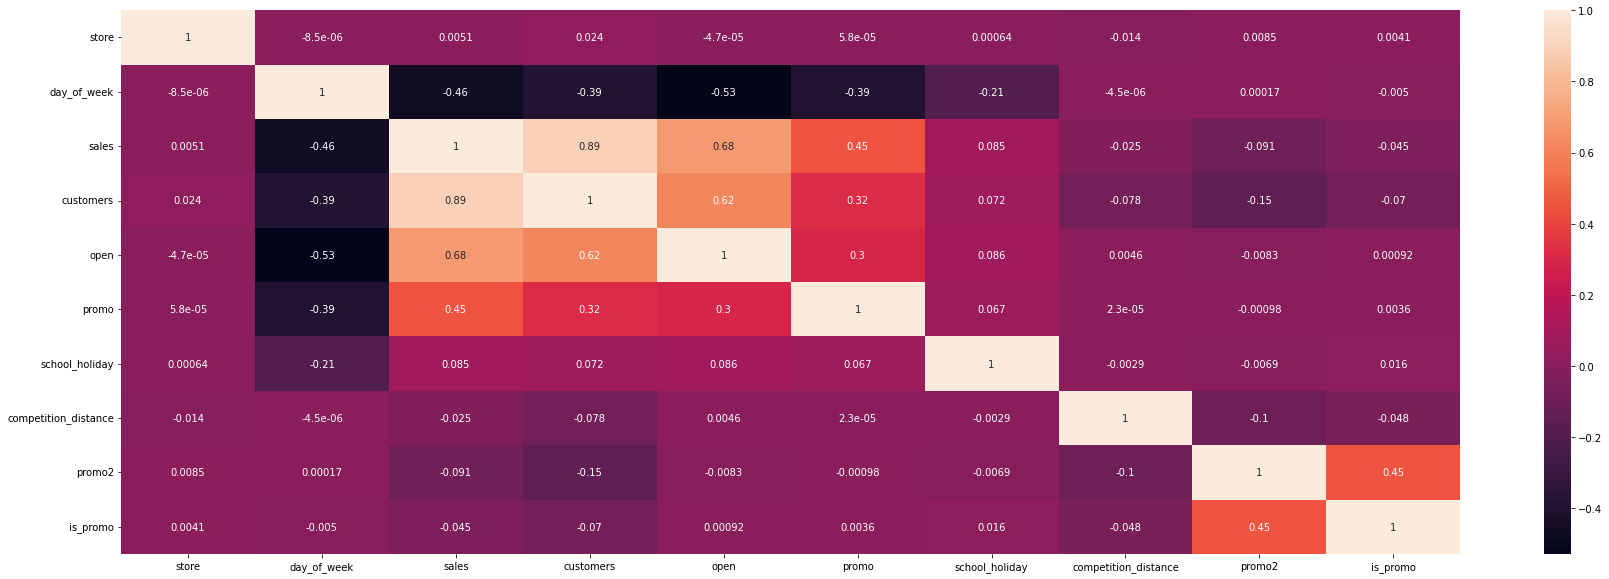

In [82]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 5.3.2. Categorical Attributes

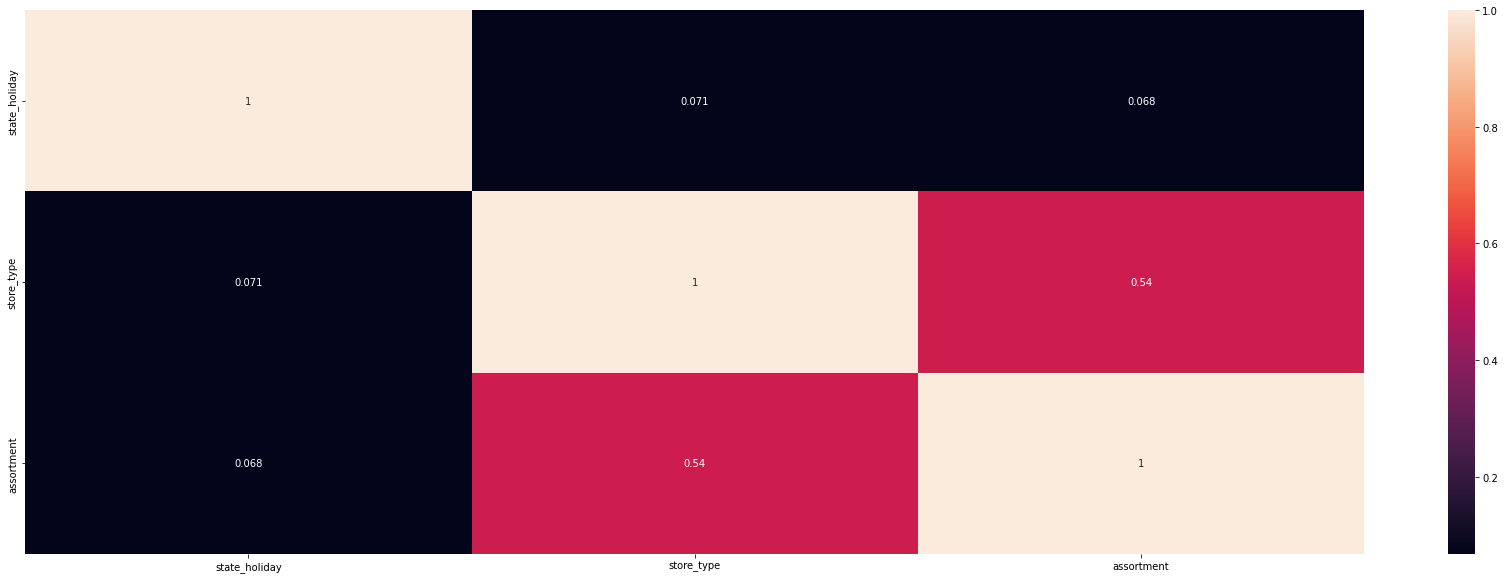

In [83]:
# categorical data only
a = df5.select_dtypes(include='object')

# cramer's v calculus
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9= cramer_v(a['assortment'],a['assortment'])

# new dataframe
d = pd.DataFrame(
    {
        'state_holiday': [a1, a2, a3],
        'store_type': [a4, a5, a6],
        'assortment': [a7, a8, a9],
    }
)

d = d.set_index(d.columns)

# heatmap
sns.heatmap(d, annot=True);

# 6.0. Data Preparation

In [86]:
# copy into a new dataset to keep the progress made until now
df6 = df5.copy()

## 6.1. Normalization

Não há variáveis com distribuição normal (ver 5.1.2)

## 6.2. Rescaling

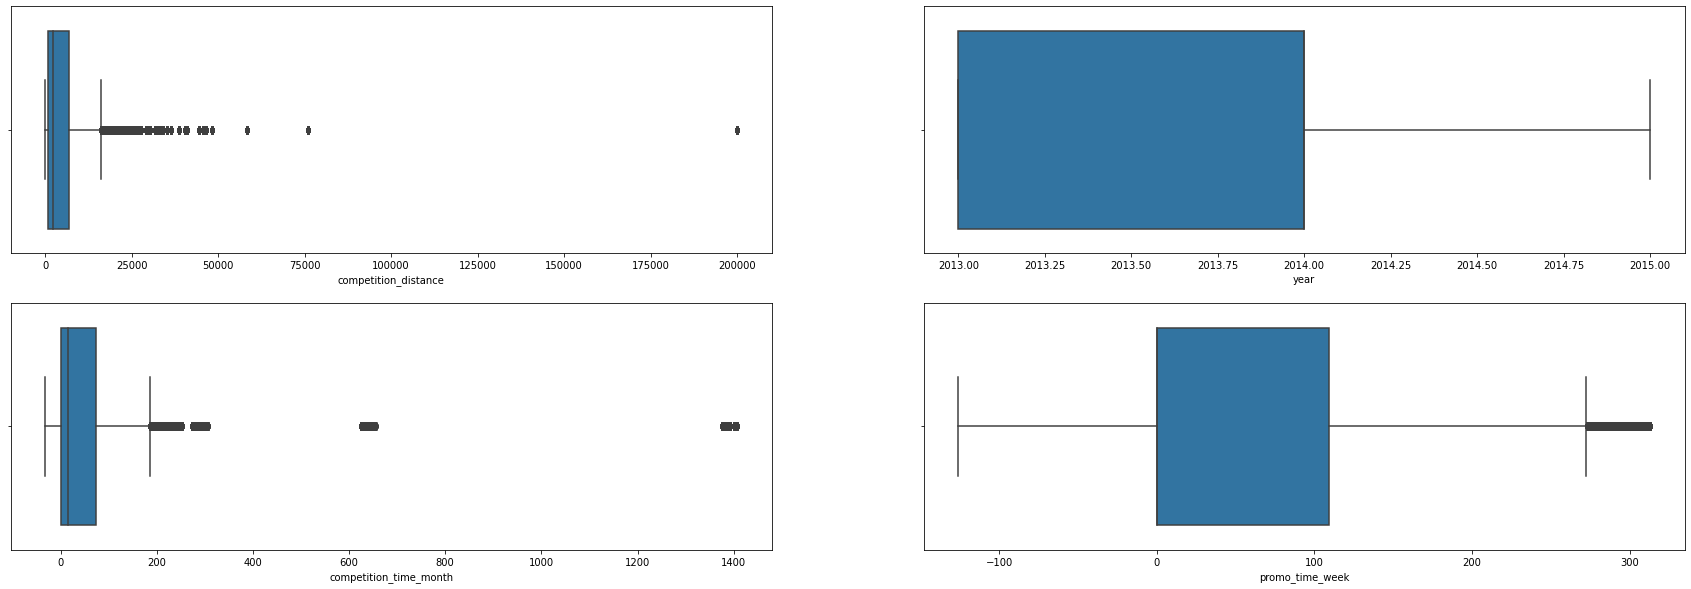

In [87]:
plt.subplot(2,2,1)
sns.boxplot(x=df6['competition_distance'])

plt.subplot(2,2,2)
sns.boxplot(x=df6['year'])

plt.subplot(2,2,3)
sns.boxplot(x=df6['competition_time_month'])

plt.subplot(2,2,4)
sns.boxplot(x=df6['promo_time_week']);

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance  
df6['re_competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
pickle.dump(rs, open('../models/parameters/competition_distance_scaler.pkl','wb'))

# year                  
df6['re_year'] = mms.fit_transform(df6[['year']].values)
pickle.dump(mms, open('../models/parameters/year_scaler.pkl','wb'))

# competition_time_month
df6['re_competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)
pickle.dump(rs, open('../models/parameters/competition_time_month_scaler.pkl','wb'))

# promo_time_week       
df6['re_promo_time_week'] = mms.fit_transform(df6[['promo_time_week']].values)
pickle.dump(rs, open('../models/parameters/promo_time_week_scaler.pkl','wb'))

## 6.3. Transformation

### 6.3.1. Encoding

In [49]:
# state_holiday - One Hot Encoding
df6 = pd.get_dummies(df6, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])
pickle.dump(le, open('../models/parameters/store_type_encoding.pkl','wb'))

# assortment - Ordinal Encoding
assortment = {
    'basic': 1,
    'extra': 2,
    'extended': 3,
}

df6['assortment'] = df6['assortment'].map(assortment)

### 6.3.2. Response Variable Transformation

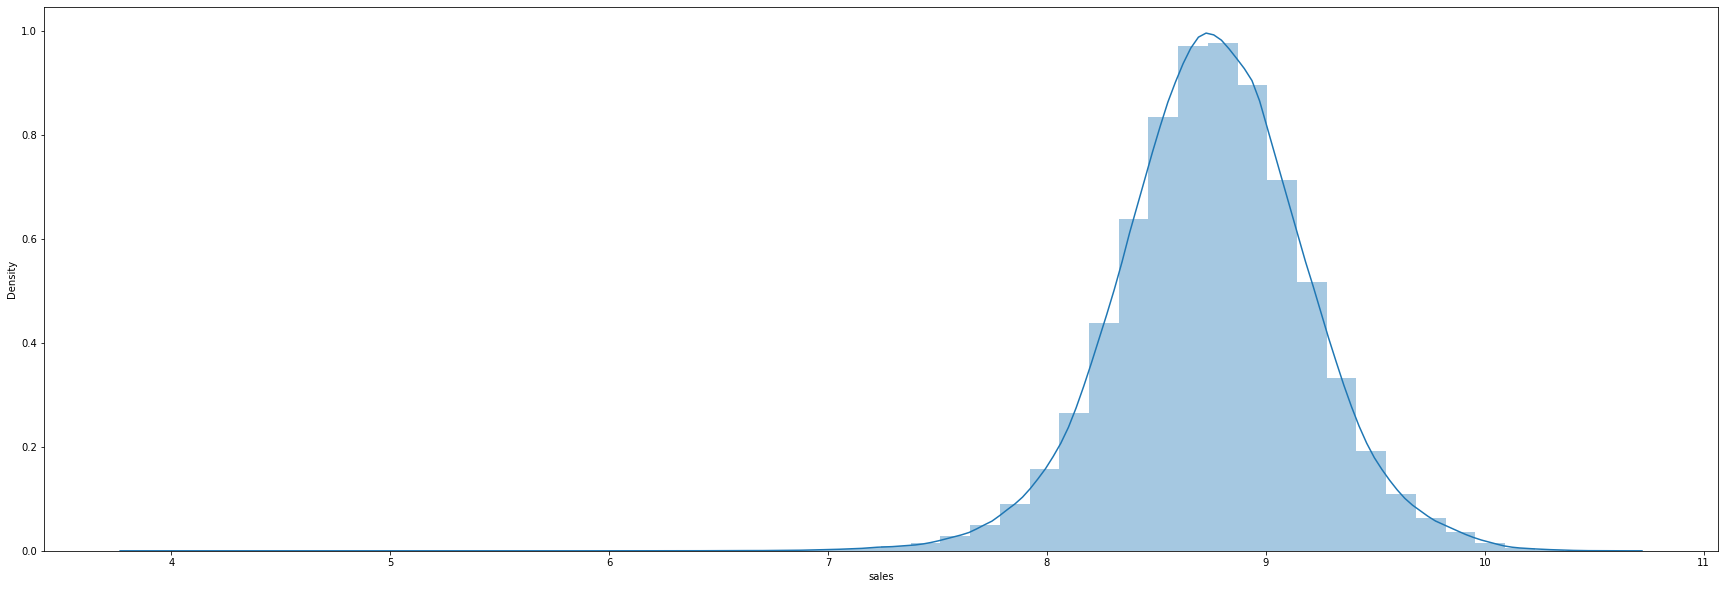

In [88]:
df6['sales'] = np.log1p(df6['sales'])
sns.distplot(df6['sales']);

### 6.3.3. Nature Transformation

In [51]:
# day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

# day          
df6['day_sin'] = df6['day'].apply(lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
df6['day_cos'] = df6['day'].apply(lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df6['month_cos'] = df6['month'].apply(lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

# week_of_year 
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )

In [52]:
df6.to_csv('../data/processed/df6.csv',index=False)

# 7.0. Feature Selection

In [53]:
# copy into a new dataset to keep the progress made until now
df7 = df6.copy()

## 7.1. Split dataframe into training and test dataset

In [54]:
cols_drop = [ 'day_of_week', 'month', 'day', 'week_of_year', 'year_week', 'competition_since', 'promo_since' ]
df7 = df7.drop( cols_drop, axis=1 )

In [55]:
# training dataset - all sales until the last 6 weeks
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset - last 6 weeks of sales
X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 7.2. Boruta as Feature Selector

In [56]:
## training and test dataset for Boruta
#X_train_n = X_train.drop(['sales','date'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=1 )
# 
## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=43).fit(X_train_n, y_train_n)

### 7.2.1 Features from Boruta

In [57]:
#cols_selected = boruta.support_.tolist()
# 
## selected boruta
#X_train_fs = X_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
# 
## not selected boruta
#cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns,cols_selected_boruta).tolist()

## 7.3. Manual Feature Selection

In [58]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
    'promo2_since_year', 'competition_time_month', 'promo_time_week', 're_competition_distance', 're_competition_time_month', 're_promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
    'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos']

pickle.dump(cols_selected_boruta, open('../data/interim/cols_boruta.pkl','wb'))

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

pickle.dump(cols_selected_boruta, open('../data/interim/cols_full.pkl','wb'))

In [59]:
df7.to_csv('../data/processed/df7.csv',index=False)

# 8.0. Machine Learning Modelling

In [60]:
# split between train and test dataset
x_train = X_train[cols_selected_boruta]
x_train.to_csv('../data/processed/x_train.csv',index=False)

x_test = X_test[cols_selected_boruta]
x_test.to_csv('../data/processed/x_test.csv',index=False)

x_training = X_train[cols_selected_boruta_full]
x_training.to_csv('../data/processed/x_training.csv',index=False)

## 8.1. Average Model

In [61]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', y_test, yhat_baseline )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 8.2. Linear Regression Model

In [62]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error('Linear Regression', y_test, yhat_lr )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1. Cross-validation

In [63]:
cv_lr_result = cross_validation(x_training, 5, 'Linear Regression', lr)
cv_lr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 8.3. Linear Regression Regularized Model - Lasso

In [64]:
# model
lrr = Lasso( alpha = 0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error('Lasso', y_test, yhat_lrr )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1869.450729,0.292784,2676.951205


### 8.3.1. Cross-validation

In [65]:
cv_lrr_result = cross_validation(x_training, 5, 'Lasso', lrr)
cv_lrr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2081.58 +/- 301.31,0.3 +/- 0.02,2958.24 +/- 473.8


## 8.4. Random Forest Regressor

In [89]:
# model
rf = RandomForestRegressor( n_estimators = 100 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error('Random Forest', y_test, yhat_rf )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.58038,0.100263,1013.112345


### 8.4.1. Cross-validation

In [90]:
cv_rf_result = cross_validation(x_training, 5, 'Random Forest', rf)
cv_rf_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.57 +/- 216.22,0.12 +/- 0.02,1257.42 +/- 318.11


## 8.5. XGBoost Regressor

In [91]:
# model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror', n_estimators = 100 ).fit( x_train, y_train )

pickle.dump(model_xgb, open('../models/model_rossmann_raw.pkl', 'wb'))

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error('XGBoost', y_test, yhat_xgb )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,868.958205,0.130309,1238.550843


### 8.5.1. Cross-validation

In [92]:
cv_xgb_result = cross_validation(x_training, 5, 'XGBoost', model_xgb)
cv_xgb_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1061.38 +/- 180.28,0.15 +/- 0.02,1515.5 +/- 244.42


## 8.6. Compare Models' Performance

In [93]:
# merge results from each model
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.580380,0.100263,1013.112345
0,XGBoost,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1869.450729,0.292784,2676.951205


### 8.6.1. Cross-validation

In [94]:
cv_modelling_result = pd.concat( [ cv_lr_result, cv_lrr_result, cv_rf_result, cv_xgb_result ] )
cv_modelling_result.reset_index(drop=True).sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
2,Random Forest,837.57 +/- 216.22,0.12 +/- 0.02,1257.42 +/- 318.11
3,XGBoost,1061.38 +/- 180.28,0.15 +/- 0.02,1515.5 +/- 244.42
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
1,Lasso,2081.58 +/- 301.31,0.3 +/- 0.02,2958.24 +/- 473.8


In [95]:
modelling_result.to_csv('../data/interim/modelling_result.csv',index=False)
cv_modelling_result.to_csv('../data/interim/cv_modelling_result.csv',index=False)

# 9. Hyperparameter Fine Tunning
Uma vez decidido qual modelo utilizar, encontrar o conjunto de parâmetros que maximiza o aprendizado deste / *After choose the model that performs best, find new parameters values in order to maximize it's learning process*

## 9.1. Random Search

In [96]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

max_eval = 10

In [97]:
final_result = pd.DataFrame()
p = []

for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print('{} > {}'.format(i, hp))
    p.append('{} > {}'.format(i+1, hp))

    # model
    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                               n_estimators = hp['n_estimators'],
                               eta = hp['eta'],
                               max_depth = hp['max_depth'],
                               subsample = hp['subsample'],
                               colsample_bytree = hp['colsample_bytree'],
                               min_child_weight= hp['min_child_weight'] )
  
    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
    final_result = pd.concat([final_result, result])  

final_result

0 > {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
1 > {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
2 > {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
3 > {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
4 > {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
5 > {'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
6 > {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
7 > {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
8 > {'n_estimators': 1

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1333.77 +/- 135.27,0.18 +/- 0.01,1936.92 +/- 183.26
0,XGBoost Regressor,812.68 +/- 119.24,0.11 +/- 0.01,1175.59 +/- 177.15
0,XGBoost Regressor,1004.6 +/- 102.57,0.14 +/- 0.01,1439.71 +/- 144.99
0,XGBoost Regressor,872.85 +/- 123.11,0.12 +/- 0.01,1256.31 +/- 178.12
0,XGBoost Regressor,794.89 +/- 128.03,0.11 +/- 0.01,1150.67 +/- 190.12
0,XGBoost Regressor,1166.67 +/- 139.7,0.16 +/- 0.01,1694.32 +/- 187.32
0,XGBoost Regressor,799.64 +/- 125.55,0.11 +/- 0.01,1161.62 +/- 187.58
0,XGBoost Regressor,1195.84 +/- 117.84,0.17 +/- 0.01,1730.49 +/- 158.81
0,XGBoost Regressor,1790.4 +/- 194.51,0.25 +/- 0.01,2567.43 +/- 262.8
0,XGBoost Regressor,825.6 +/- 134.72,0.12 +/- 0.01,1189.08 +/- 195.05


In [98]:
final_result.reset_index(drop=True).to_csv('../data/interim/final_result.csv', index=False)
pickle.dump(p, open('../models/parameters/parameters_fine_tuning.pkl', 'wb'))

## 9.2. Final Model
Modelo treinado com os parametros encontrados o fine tuning / *Training model with the beat parameters found in fine tuning*

In [99]:
param_tuned = {
   'n_estimators': 3000,
   'eta': 0.03,
   'max_depth': 9,
   'subsample': 0.5,
   'colsample_bytree': 0.9,
   'min_child_weight': 8 
}

In [100]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'],
                              eta = param_tuned['eta'],
                              max_depth = param_tuned['max_depth'],
                              subsample = param_tuned['subsample'],
                              colsample_bytree = param_tuned['colsample_bytree'],
                              min_child_weight= param_tuned['min_child_weight'] ).fit( x_train, y_train )

# save/load model externally
pickle.dump(model_xgb_tuned, open('../models/model_rossmann_tuned.pkl', 'wb'))

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error('XGBoost', y_test, yhat_xgb_tuned)
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,624.300053,0.090312,914.256606


# 10. Error Interpretation
Entender os valores de MAE/MAPE/RMSE/MPE e traduzi-los para visão de negócio / *Analyse error values (MAE/MAPE/RMSE/MPE) and translate into business results*

In [101]:
# copy into a new dataset to keep the progress made until now
df10 = X_test[cols_selected_boruta_full].copy()

# rescale result feature back from log
df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1( yhat_xgb_tuned )

df10.to_csv('../data/processed/df10.csv',index=False)

## 10.1. Business Performance
Como reportar o resultado do modelo em termos de negócio / *Translate model's results to the business team*

In [102]:
# sum of predictions
_df10 = df10[['predictions','store']].groupby('store').sum().reset_index()

# MAE and MAPE
df10_aux1 = df10[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df10_aux2 = df10[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})
df10_aux3 = pd.merge(df10_aux1, df10_aux2, how='inner', on='store')
df10_aux = pd.merge(_df10, df10_aux3, how='inner', on='store')

# scenarios
df10_aux['worst_scenario'] = df10_aux['predictions'] - df10_aux['MAE']
df10_aux['best_scenario'] = df10_aux['predictions'] + df10_aux['MAE']

# order columns
df10_aux

,store,predictions,MAE,MAPE,worst_scenario,best_scenario
0,1,159628.031250,262.098151,0.059285,159365.933099,159890.129401
1,2,176358.875000,369.802530,0.074712,175989.072470,176728.677530
2,3,260626.437500,517.956596,0.076137,260108.480904,261144.394096
3,4,342657.218750,882.539577,0.083825,341774.679173,343539.758327
4,5,170447.562500,370.270851,0.086022,170077.291649,170817.833351
...,...,...,...,...,...,...
1110,1111,177123.265625,596.692587,0.127058,176526.573038,177719.958212
1111,1112,334855.500000,928.564664,0.113358,333926.935336,335784.064664
1112,1113,233514.593750,550.355667,0.082764,232964.238083,234064.949417
1113,1114,755635.062500,2614.108689,0.111972,753020.953811,758249.171189


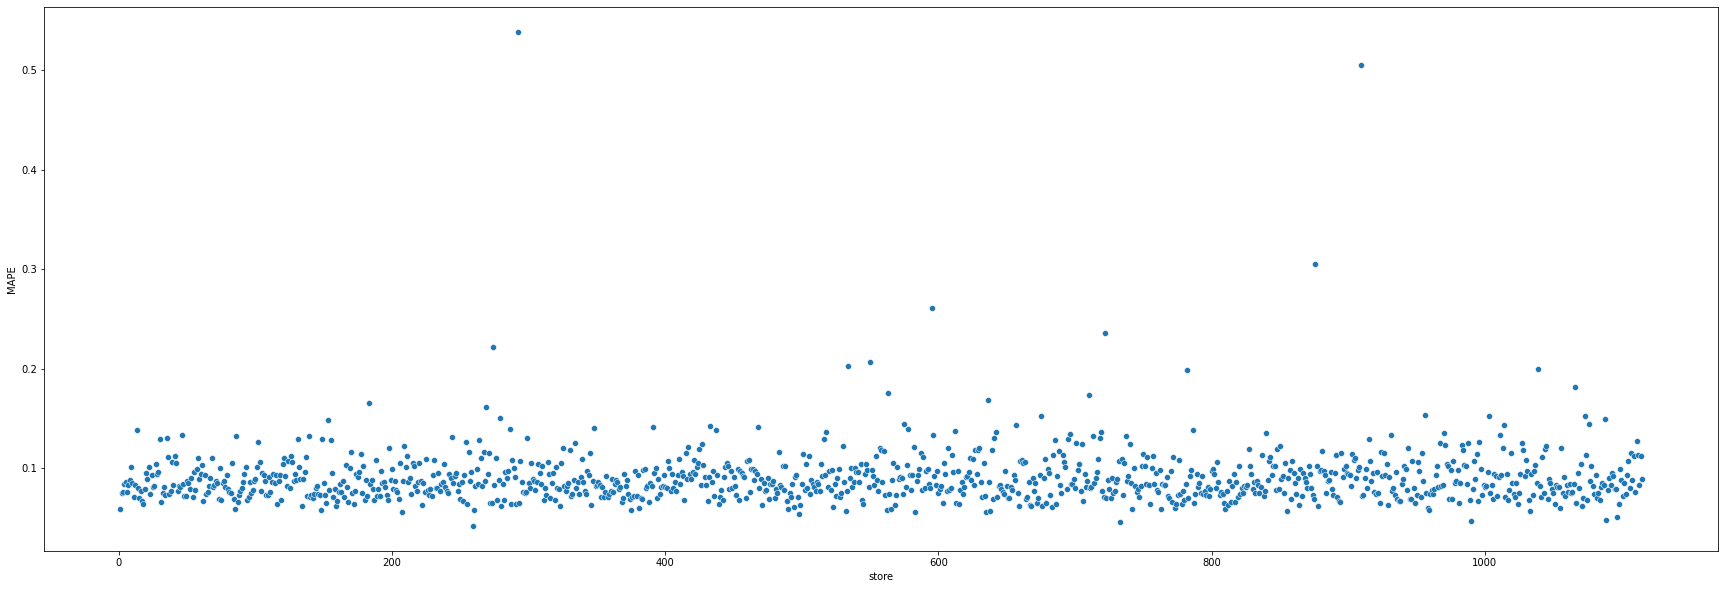

In [103]:
# MAPE distribuition
sns.scatterplot(data=df10_aux,x='store', y='MAPE');

## 10.2. Total Performance
Resultado estimado da implantação do modelo treinado / *Estimated results after model's implementation*

In [104]:
a = df10_aux[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
a['Values'] = a['Values'].map('{:,.2f}'.format)
a

,Scenario,Values
0,predictions,"283,489,440.00"
1,worst_scenario,"282,789,283.95"
2,best_scenario,"284,189,602.47"


## 10.3. Machine Learning Performance

In [105]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']

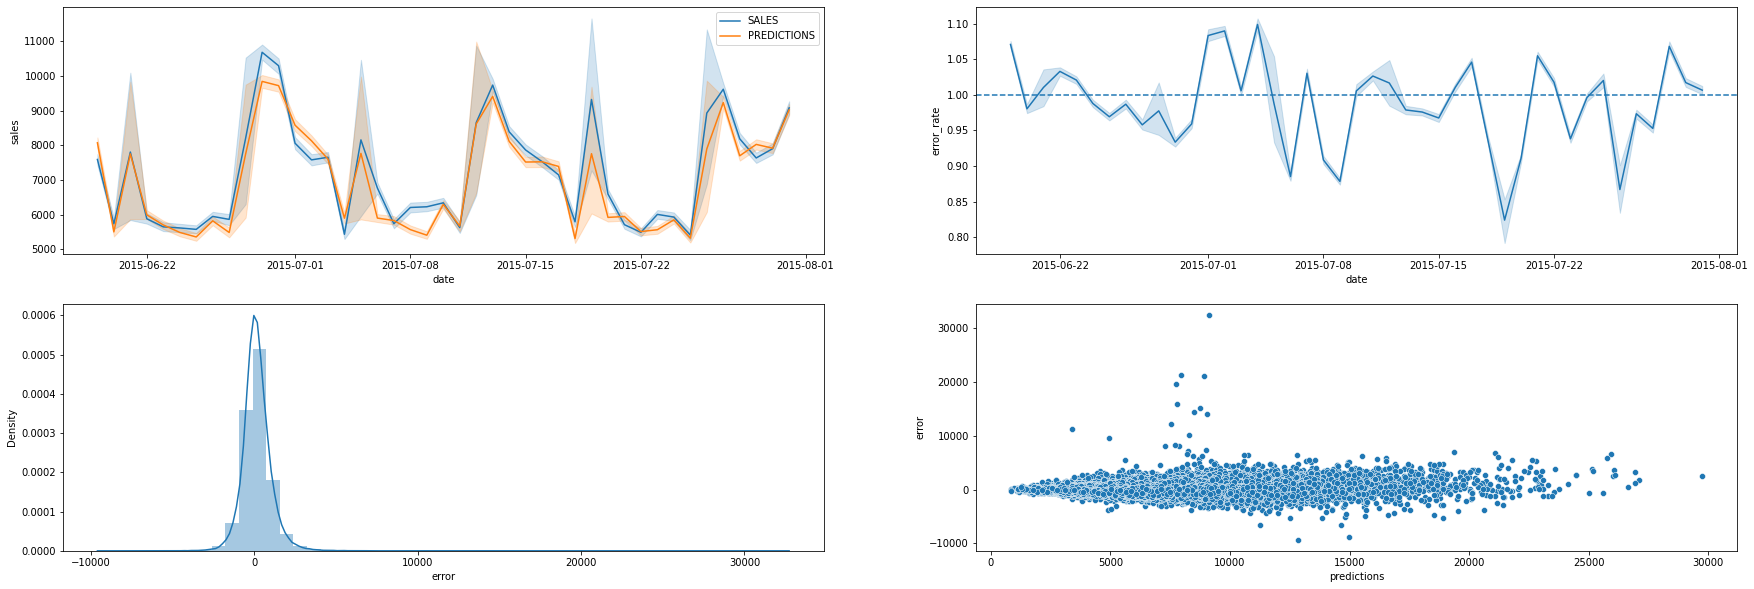

In [106]:
plt.subplot(2,2,1)
sns.lineplot(data=df10, x='date', y='sales', label='SALES')
sns.lineplot(data=df10, x='date', y='predictions', label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(data=df10, x='date', y='error_rate')
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df10['error'])

plt.subplot(2,2,4)
sns.scatterplot(data=df10, x='predictions', y='error');

# 11. Deploy to production

## 11.1. Rossmann Class
Classe em python com os metodos de limpeza e tranformação de dados, além da predição / *Python class with methods for data cleaning/transformation and prediction*

In [ ]:
import pickle
import pandas as pd
import inflection
import numpy as np
import datetime
import math

class Rossmann ( object ):
    
    def __init__( self ):
        self.home='/PATH/'
        self.competition_distance_scaler   = pickle.load(open(self.home + 'parameter/competition_distance_scaler','rb'))
        self.year_scaler                   = pickle.load(open(self.home + 'parameter/year_scaler','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home + 'parameter/competition_time_month_scaler','rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home + 'parameter/promo_time_week_scaler','rb'))
        self.store_type_encoding           = pickle.load(open(self.home + 'parameter/store_type_encoding','rb'))
        self.model_xgb                     = pickle.load(open(self.home + 'model/model_rossmann.pkl', 'rb') )
        
    def data_cleaning( self, df1 ):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
                    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snake_case = lambda x: inflection.underscore(x)
        cols_new = list(map(snake_case,cols_old))
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NAs

        # competition_distance: 
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

        # competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

        # promo2_since_week 
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )         

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )                 

        # promo_interval  
        month_map = { 1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' } 
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map( month_map ) # extrai o mês int e mapeia com o dicionario, tranformando em string
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6. Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering( self, df3 ):
        # year
        df3['year'] = df3['date'].dt.year

        # month
        df3['month'] = df3['date'].dt.month

        # day
        df3['day'] = df3['date'].dt.day

        # week of year
        df3['week_of_year'] = df3['date'].dt.weekofyear

        # year week
        df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

        # competition since
        df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'],
                                                                          month = x['competition_open_since_month'], 
                                                                          day=1), axis=1 )
        df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype(int)

        # promo since
        df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
        df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype(int)

        # assortment
        df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 4.0. Variables filtering
        ## 4.1. Rows filtering
        df3 = df3[df3['open'] != 0]

        ## 4.2. Columns selection

        cols_drop = ['open','promo_interval','month_map']
        df3 = df3.drop(cols_drop, axis=1)
        
        return df3
    
    def data_preparation( self, df6 ):

        ## 6.2. Rescaling
        # competition_distance  
        df6['re_competition_distance'] = self.competition_distance_scaler.transform(df6[['competition_distance']].values)

        # year                  
        df6['re_year'] = self.year_scaler.transform(df6[['year']].values)

        # competition_time_month
        df6['re_competition_time_month'] = self.competition_time_month_scaler.transform(df6[['competition_time_month']].values)

        # promo_time_week       
        df6['re_promo_time_week'] = self.promo_time_week_scaler.transform(df6[['promo_time_week']].values)


        ## 6.3. Transformação
        ### 6.3.1. Encoding

        # state_holiday - One Hot Encoding
        df6 = pd.get_dummies(df6, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df6['store_type'] = self.store_type_encoding.transform(df6['store_type'])

        # assortment - Ordinal Encoding
        assortment = { 'basic': 1,'extra': 2, 'extended': 3 }

        df6['assortment'] = df6['assortment'].map(assortment)

        ### 6.3.3. Nature Transformation (variaveis cíclicas)

        # day_of_week
        df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
        df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

        # day          
        df6['day_sin'] = df6['day'].apply(lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
        df6['day_cos'] = df6['day'].apply(lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

        # month
        df6['month_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
        df6['month_cos'] = df6['month'].apply(lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

        # week_of_year 
        df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
        df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
        'promo2_since_year', 'competition_time_month', 'promo_time_week', 're_competition_distance', 're_competition_time_month', 're_promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
        'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df6[cols_selected]
    
    def prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')


## 11.2. API Handler
Classe responsável por fazer a comunicação entre o dispositivo solicitante e os métodos da classe Rossmann / *Listener for requests to Rossmann class*

In [ ]:
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pandas as pd
import pickle

# loading model
model = pickle.load( open('model/model_rossmann.pkl', 'rb') )

app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    
    test_json = request.get_json()
    
    if test_json: #there's data
        
        if isinstance(test_json,dict): #unique example
            test_raw = pd.DataFrame(test_json, index[0])
        else: #multiple exemple
            test_raw = pd.DataFrame(test_json, columns=index[0].keys())
            
        # instantiate rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}',status=200,mimetype='application/json')
       
if __name__ == '__main__':
    app.run('0.0.0.0')

## 11.3. API Tester
Simulador de requisições de predição / *Requests simulator*

In [218]:
import pandas as pd
import requests
import json

# loading test dataset
df10 = pd.read_csv('../data/raw/test.csv')
df_store_raw = pd.read_csv('../data/raw/store.csv')

# merge test + store datasets
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[(df_test['Open'] != 0) & (~df_test['Open'].isnull())]
df_test = df_test.drop('Id', axis=1)

# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

# API call
#url = 'http://192.168.0.115:5000/rossmann/predict'
url = 'https://dsr-rossmannsales.herokuapp.com/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [219]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print('Store number {} will sell US${:,.2f} in the next 6 weeks'.format(
    d2.loc[i,'store'], d2.loc[i,'prediction']))

Store number 22 will sell US$199,079.47 in the next 6 weeks


In [217]:
url = 'https://dsr-rossmannsales.herokuapp.com/reports'
header = {'Content-type': 'application/json'}
plot_data = json.dumps(d1.to_dict(orient='records'))

r = requests.post(url, data=plot_data, headers=header)
print('Status code {}'.format(r.status_code))

Status code 500


In [220]:
dtest = d1[['date','prediction']]
dtest['date'] = pd.to_datetime(pd.to_datetime(dtest['date']).dt.strftime('%Y-%m-%d'))
dtest['day_of_month'] = dtest['date'].apply(lambda x: x.month_name()[0:3] + ', ' + (str(x.day)+'st' if x.day == 1 else str(x.day)+'nd' if x.day == 2 else str(x.day)+'rd' if x.day == 3 else str(x.day)+'th'))

dtest = dtest.sort_values('date').reset_index(drop=True)

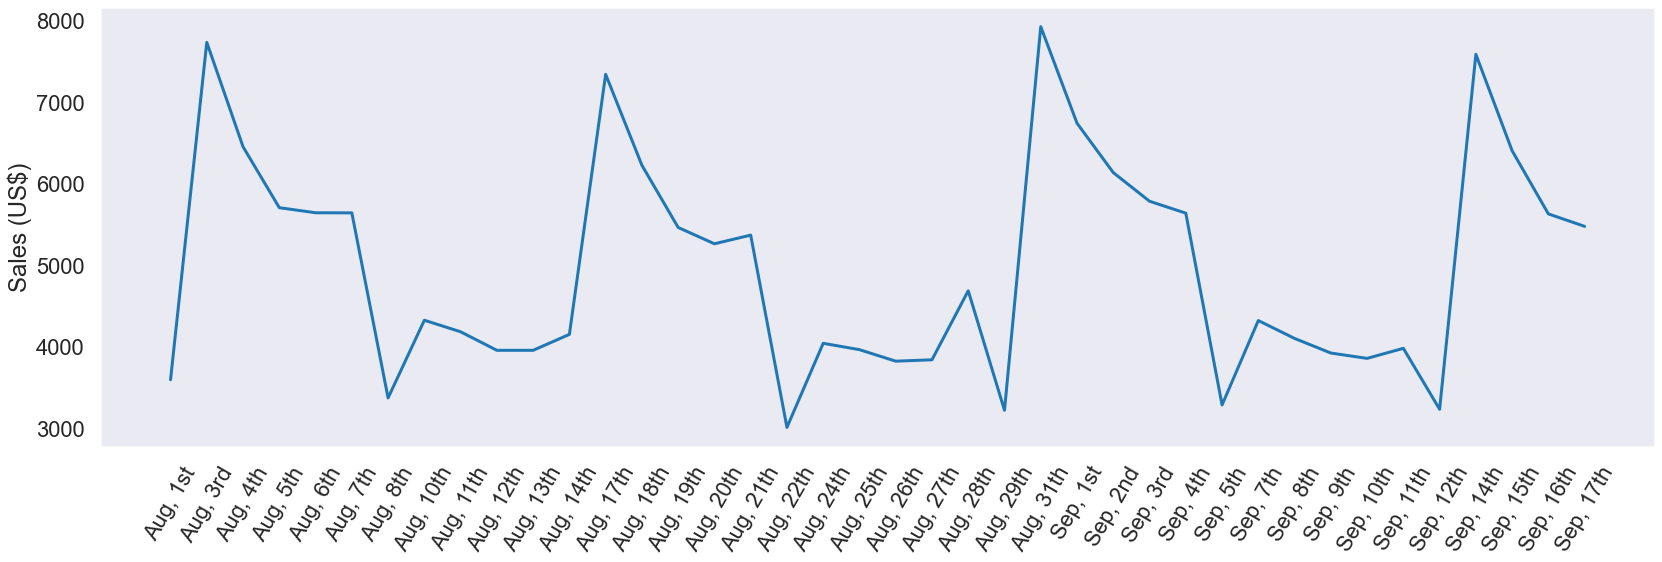

In [226]:
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(1700*px,600*px), tight_layout=True)
sns.set_context("poster")
sns.set_style("dark")
g = sns.lineplot(data=dtest, x='day_of_month', y='prediction')
g.set_ylabel('Sales (US$)')
g.set_xlabel('')
plt.xticks(rotation=60);